In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# Image properties

img_width = 128
img_height = 128
img_channel = 3
img_size = (img_width, img_height)

In [5]:
# Dataset preparation

filenames = os.listdir("<filepath>")

categories = []

for f_name in filenames:
    category = f_name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({'filename' : filenames,
                  'category' : categories})
        
        

In [8]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [11]:
# Creating a neural network

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32,(3,3), activation ='relu', input_shape = (img_width, img_height, img_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(64,(3,3), activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(128,(3,3), activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation = 'softmax'))


model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [13]:
# Callbacks and LR

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(patience = 10)
lrr = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)

callbacks = [early_stop, lrr]

In [14]:
# Managing data

df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [27]:
# Training and validation generator

train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df,"<filepath>",
                                                    x_col='filename',y_col='category',
                                                    target_size=img_size,
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              "<filepath>",
                                                              x_col='filename',y_col='category',
                                                              target_size=img_size,
                                                              class_mode='categorical',
                                                              batch_size=batch_size)

test_datagen = ImageDataGenerator(rotation_range=15,
                                  rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)

test_filenames = os.listdir("<filepath>")
test_df = pd.DataFrame({
    'filename': test_filenames
})

test_generator = train_datagen.flow_from_dataframe(test_df,
                                                   "<filepath>",x_col='filename',
                                                   y_col = None,
                                                   target_size=img_size,
                                                   class_mode=None,
                                                   batch_size=batch_size)

nb_samples = test_df.shape[0]

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


In [22]:
# Model training

epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 1844s 1s/step - loss: 0.7379 - accuracy: 0.6313 - val_loss: 0.6243 - val_accuracy: 0.6839
Epoch 2/10


C:\Users\haima\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1333/1333 [==============================] - 1761s 1s/step - loss: 0.5622 - accuracy: 0.7188 - val_loss: 0.3719 - val_accuracy: 0.7332
Epoch 3/10
1079/1333 [=======================>......] - ETA: 5:58 - loss: 0.5052 - accuracy: 0.7590

C:\Users\haima\Anaconda3\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 697 could not be retrieved. It could be because a worker has died.
  UserWarning)


1333/1333 [==============================] - 2284s 2s/step - loss: 0.5015 - accuracy: 0.7621 - val_loss: 0.3190 - val_accuracy: 0.8080
Epoch 4/10
1266/1333 [===========================>..] - ETA: 1:25 - loss: 0.4669 - accuracy: 0.7867

C:\Users\haima\Anaconda3\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 948 could not be retrieved. It could be because a worker has died.
  UserWarning)


1333/1333 [==============================] - 1961s 1s/step - loss: 0.4641 - accuracy: 0.7873 - val_loss: 1.3273 - val_accuracy: 0.6704
Epoch 5/10
 761/1333 [================>.............] - ETA: 13:16 - loss: 0.4508 - accuracy: 0.7928

C:\Users\haima\Anaconda3\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 990 could not be retrieved. It could be because a worker has died.
  UserWarning)


1332/1333 [============================>.] - ETA: 1s - loss: 0.4485 - accuracy: 0.7942

C:\Users\haima\Anaconda3\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 219 could not be retrieved. It could be because a worker has died.
  UserWarning)


1333/1333 [==============================] - 2101s 2s/step - loss: 0.4484 - accuracy: 0.7942 - val_loss: 1.2984 - val_accuracy: 0.6768
Epoch 6/10
1333/1333 [==============================] - 1980s 1s/step - loss: 0.4191 - accuracy: 0.8105 - val_loss: 0.4645 - val_accuracy: 0.7817
Epoch 7/10
1333/1333 [==============================] - 2082s 2s/step - loss: 0.4093 - accuracy: 0.8178 - val_loss: 0.4273 - val_accuracy: 0.8166
Epoch 8/10
1333/1333 [==============================] - 2030s 2s/step - loss: 0.3951 - accuracy: 0.8250 - val_loss: 0.6044 - val_accuracy: 0.8377
Epoch 9/10
1333/1333 [==============================] - 2028s 2s/step - loss: 0.3938 - accuracy: 0.8257 - val_loss: 0.4428 - val_accuracy: 0.8512
Epoch 10/10
1333/1333 [==============================] - 1929s 1s/step - loss: 0.3839 - accuracy: 0.8315 - val_loss: 0.2303 - val_accuracy: 0.8162


In [32]:
# Save model

model.save("CatsVsDogs_model_10Epoch.h5")

In [33]:
# Categorical predictions

test_generator.reset()
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [34]:
# Converting labels to categories

test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

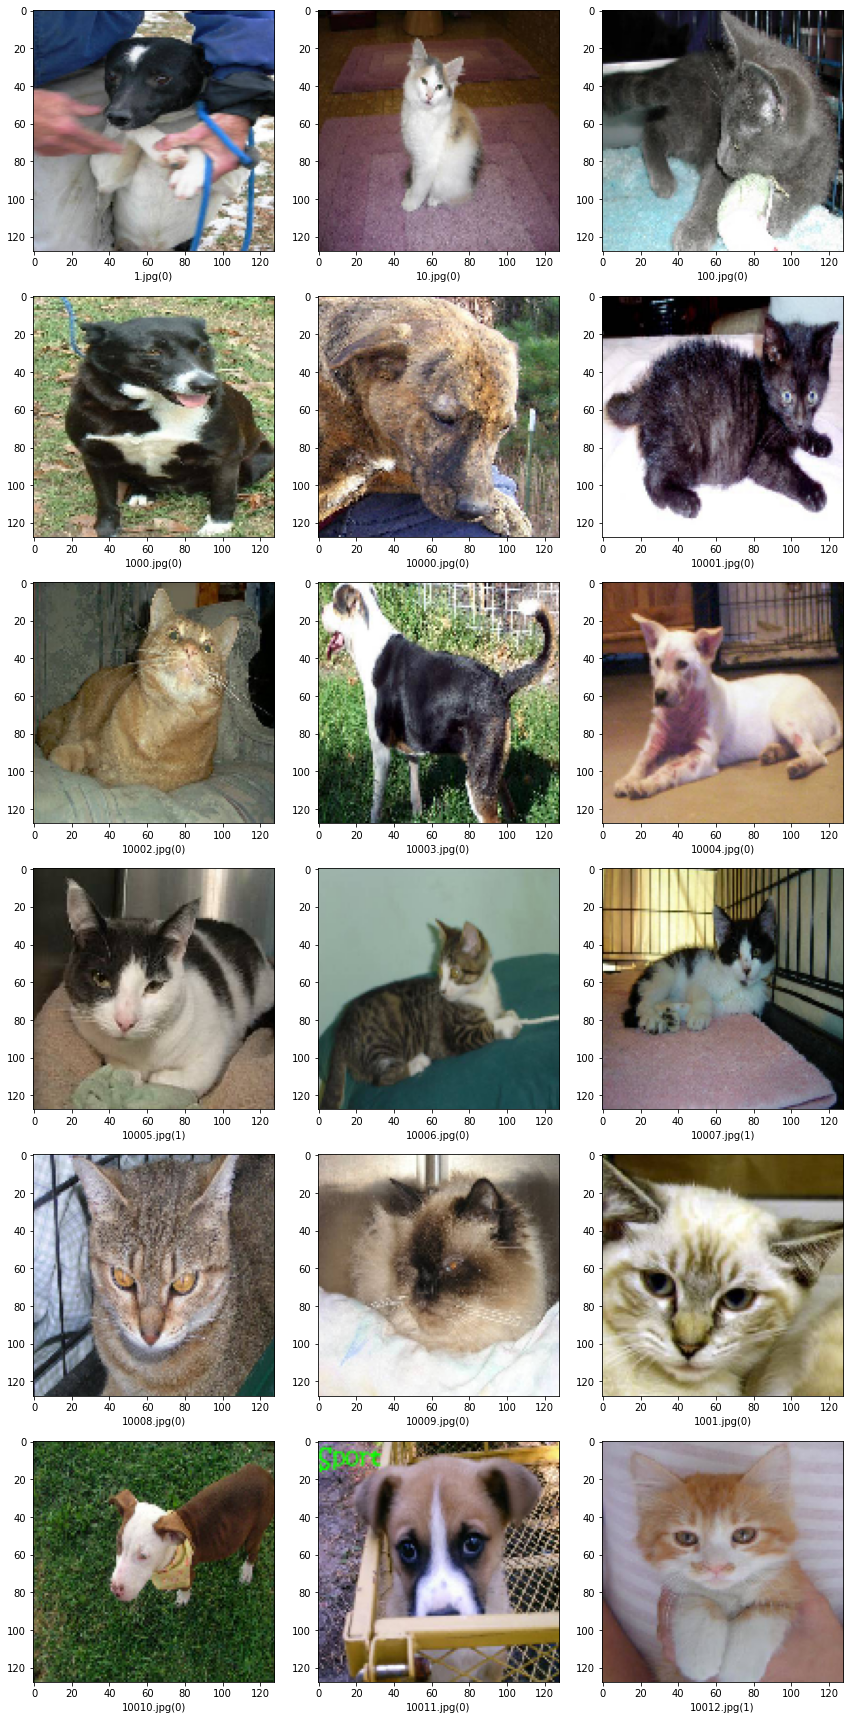

In [35]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("<filepath>"+ filename, target_size=img_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [40]:
results={
    0:'cat',
    1:'dog'
}
from PIL import Image
import numpy as np
im=Image.open("<custom_image_filepath>")
im=im.resize(img_size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict_classes([im])[0]
print(pred,results[pred])

0 cat
